# VSA Common Bundle Trend
- Previously from [VSA Recall Datatypes](./vsa_recall_datatypes.ipynb) and [VSA Non Flatten Bundle](./vsa_non_flatten_bundle.ipynb) we theoretically and empirically proved two things:
  - Regardless of datatypes the mean is consistent throughout the dimension, but the variance decreases with increasing dimension.
  - With increasing dimension, the amount of bundled vectors (assuming all components are orthogonal) increases linearly with dimension.
  - Regardless of data type, there is a slight advantage for using non-binary (e.g., bipolar, integer, real) but not that conclusive as increase in bundle capacity is not that high even at high dimensions (< 10 elements).
  - If we do not flatten the bundle (i.e., majority vote or sign-magnitude flattening) the effective similarity mean increases, consequently, the number of bundled vectors increases as well.
- In this notebook investigation, we will see the limits of bundling but comparing with two bundled HVs with common elements.
  - Moreover, we will investigate only the case for binary as we know that using integer or real lengthens simulation but at the same time it also makes things slightly better only.

In [1]:
# Import library
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm

# Gets directory where script was launched from
script_dir = os.getcwd()  
script_dir = script_dir + "/../lib/"
print(f"VSA Library: {script_dir}")

# Add the directory to Python's search path
sys.path.append(script_dir)  

import vsa as vsa
import vsa_func as vsaf
import vsa_profile as vsap

VSA Library: \\wsl.localhost\Ubuntu\home\rantonio\chronomatica\vsa/../lib/


In [97]:
# Parameters to modify
HV_DIM = 1024
# Use odd number NUM_ITEMS to avoid ties when bundling
NUM_ITEMS = 501
TOTAL_BUNDLE_ELEM = 501
THRESHOLD = NUM_ITEMS / 2
NUM_TRIALS = 100
HV_DIM_LIST = [1024, 2048, 4096, 8192]
COMMON_BUNDLE_LIST = np.arange(3, TOTAL_BUNDLE_ELEM+1, 2)

In [105]:
def calculate_mean_std(score_matrix):
    mean_vec = np.mean(score_matrix, axis=0)
    std_vec = np.std(score_matrix, axis=0)
    return mean_vec, std_vec

In [109]:
def im_bundle_scores(num_trials, num_items, hv_dim, disable_tqdm=False, im_type="binary"):
    score_matrix  = np.zeros((num_trials, len(COMMON_BUNDLE_LIST)))

    for i in tqdm.tqdm(range(num_trials), desc=f"Trials D={hv_dim}", disable=disable_tqdm):
        # Generate the item memories
        im_common_set = vsaf.gen_orthogonal_im(num_items, hv_dim, type=im_type)
        im_set_1 = vsaf.gen_orthogonal_im(num_items, hv_dim, type=im_type)
        im_set_2 = vsaf.gen_orthogonal_im(num_items, hv_dim, type=im_type)

        for j, NUM_COMMON_ELEM in enumerate(COMMON_BUNDLE_LIST):
            NUM_UNCOMMON_ELEM = TOTAL_BUNDLE_ELEM - NUM_COMMON_ELEM

            combine_set_1 = np.concatenate((im_common_set[0:NUM_COMMON_ELEM], im_set_1[0:NUM_UNCOMMON_ELEM]))
            combine_set_2 = np.concatenate((im_common_set[0:NUM_COMMON_ELEM], im_set_2[0:NUM_UNCOMMON_ELEM]))

            THRESHOLD = TOTAL_BUNDLE_ELEM / 2
            bundled_im_set_0 = vsa.hv_add(combine_set_1, threshold=THRESHOLD)
            bundled_im_set_1 = vsa.hv_add(combine_set_2, threshold=THRESHOLD)

            score_matrix[i, j] = 1 - vsa.hv_ham(bundled_im_set_0, bundled_im_set_1)
    
    return score_matrix


In [110]:
binary_mean_trend = {}
binary_stddev_trend = {}
for i in tqdm.tqdm(range(len(HV_DIM_LIST)), desc="Dimension"):
    binary_score_D = im_bundle_scores(NUM_TRIALS, NUM_ITEMS, HV_DIM_LIST[i], disable_tqdm=True,im_type="binary")
    binary_mean_trend[HV_DIM_LIST[i]], binary_stddev_trend[HV_DIM_LIST[i]] = calculate_mean_std(binary_score_D)


Dimension: 100%|██████████| 4/4 [29:06<00:00, 436.71s/it]


In [123]:
def plot_dimension_change(x, hv_dim_list, mean_trend, stddev_trend, func_mean_var, subplot_shape, xytext_offset=(5,10), set_ylim=(0.5,0.6), im_type="binary"):

    # Some base variables and settings
    alpha = 0.4
    row_idx = 0
    col_idx = 0
    max_rows, max_cols = subplot_shape

    # Set figure size
    fig, axes = plt.subplots(max_rows, max_cols, figsize=(10, 10), dpi=100)

    for i, D in enumerate(hv_dim_list):
        row_idx = i // max_cols
        col_idx = i % max_cols

        mu, std, _ = func_mean_var(D)

        # Create a line for the mean and sim cut score
        if im_type == "binary":
            mu_line = np.array([mu/D] * len(x))
            std_line = np.array([3*std/D] * len(x))
        else:
            mu_line = np.array([mu] * len(x))
            std_line = np.array([3*std] * len(x))

        # Plot ideal mean and std lines
        if im_type == "binary":
            axes[row_idx, col_idx].plot(x, mu_line, color='green', label=f"Theoretical $\mu$ = {mu/D:.3f}" )
            axes[row_idx, col_idx].fill_between(x, mu_line - std_line, mu_line + std_line, alpha=0.2, color='green', label=f"Theoretical $3\sigma$ = {3*std/D:.3f}" )
        else:
            axes[row_idx, col_idx].plot(x, mu_line, color='green', label=f"Theoretical $\mu$ = {mu:.3f}" )
            axes[row_idx, col_idx].fill_between(x, mu_line - std_line, mu_line + std_line, alpha=0.2, color='green', label=f"Theoretical $3\sigma$ = {3*std:.3f}" )


        # Get cut for the score
        if im_type == "binary":
            sim_cut_score = np.array([(mu + 3*std) / D] * len(x))
        else:
            sim_cut_score = np.array([(mu + 3*std)] * len(x))

        # Highlight point of intersection between the sim_cut_score and mean_vec
        intersection_index = np.where((mean_trend[D] - 3*stddev_trend[D]) >= sim_cut_score)[0][0]
        # Plot point of intersection only
        axes[row_idx, col_idx].plot(x[intersection_index], (mean_trend[D] - 3*stddev_trend[D])[intersection_index], 'o', color='blue')
        # Plot cross line
        sim_cut_actual_score = [(mean_trend[D] - 3*stddev_trend[D])[intersection_index]]*len(x)
        axes[row_idx, col_idx].plot(x, sim_cut_actual_score, linestyle='--', color='gray' )
        axes[row_idx, col_idx].axvline(x[intersection_index], linestyle='--', color='gray')

        axes[row_idx, col_idx].annotate(
            f"({x[intersection_index]}, {mean_trend[D][intersection_index]:.3f})",
            xy=(x[intersection_index], (mean_trend[D] - stddev_trend[D])[intersection_index]),
            xytext=xytext_offset,  # offset in points (x, y)
            textcoords="offset points",
            fontsize=12,
            ha="left",
            va="bottom"
        )
        # Plot the points
        axes[row_idx, col_idx].plot( x, mean_trend[D], 
                        linewidth=2, color="red",
                        label=f"Empirical $\mu$ = {mean_trend[D][intersection_index]:.3f}")
        axes[row_idx, col_idx].fill_between( 
            x, 
            mean_trend[D] - 3*stddev_trend[D], 
            mean_trend[D] + 3*stddev_trend[D], 
            alpha=alpha,
            label=f"Empirical $3\sigma$ = {3*stddev_trend[D][intersection_index]:.3f}"
        )
        axes[row_idx, col_idx].set_title(f"D={D}")
        axes[row_idx, col_idx].set_ylim(set_ylim)
        axes[row_idx, col_idx].legend(loc='upper right')

    # Add labels and title
    plt.xlabel("Common Size for 501 Bundle Elements")
    plt.ylabel("Sim Score")
    plt.show()



In [124]:
def expected_mean_std_var(D):
    mu = D / 2
    var = D / 4
    std = np.sqrt(var)
    return mu, std, var

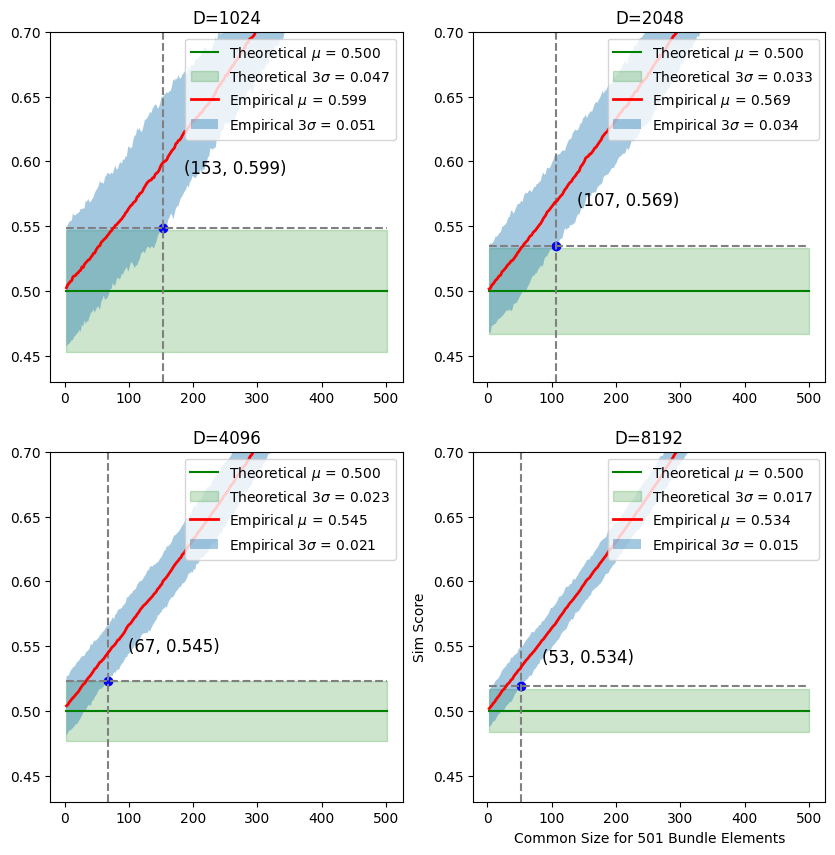

In [125]:
plot_dimension_change(
    COMMON_BUNDLE_LIST, 
    HV_DIM_LIST,
    binary_mean_trend, 
    binary_stddev_trend, 
    expected_mean_std_var, 
    subplot_shape=(2,2), 
    xytext_offset=(15,5),
    set_ylim=(0.43,0.7),
)

## Conclusion
- This experiment is important as it tells us that we can get out of the noisy trench when we compare two bundles that has a significant amount of similarity.
- For example, at $D=1024$ the noise is high and a single element of the bundle cannot be determined. However, when we have a representation which is a subset of the other, the amount of similarity increases more and more until it overcomes the noise.
- How we interpret the above figure is that (for example at $D=1024$) we need at least 153 common elements at the munimum such at a total bundle size of 501 to be distinguishable from noise. 
- The distance score (similarity score) is also an indicator that this is the minimum score in order to be distinguishable from noise.
- This is why 